In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from sklearn.mixture import GaussianMixture
from dataclasses import dataclass
from typing import List, Tuple, Optional
import cv2
from PIL import Image

plt.style.use('default')
%matplotlib inline

In [9]:
@dataclass
class Gaussian2D:
    mu_x: float
    mu_y: float
    sigma_xx: float
    sigma_yy: float
    sigma_xy: float
    amplitude: float
    color: np.ndarray
    
    def __post_init__(self):
        if isinstance(self.color, (list, tuple)):
            self.color = np.array(self.color)
    
    @property
    def covariance_matrix(self) -> np.ndarray:
        return np.array([[self.sigma_xx, self.sigma_xy],
                        [self.sigma_xy, self.sigma_yy]])
    
    @property 
    def mean_vector(self) -> np.ndarray:
        return np.array([self.mu_x, self.mu_y])
    
    def evaluate_at(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        pos = np.dstack((x, y))
        return self.amplitude * multivariate_normal.pdf(
            pos, self.mean_vector, self.covariance_matrix
        )
    
    def get_bounding_box(self, n_sigma: float = 3.0) -> Tuple[int, int, int, int]:
        eigenvals = np.linalg.eigvals(self.covariance_matrix)
        max_std = np.sqrt(np.max(eigenvals))
        
        radius = n_sigma * max_std
        x_min = int(np.floor(self.mu_x - radius))
        x_max = int(np.ceil(self.mu_x + radius))
        y_min = int(np.floor(self.mu_y - radius))
        y_max = int(np.ceil(self.mu_y + radius))
        
        return x_min, y_min, x_max, y_max


In [4]:
class GaussianImageRepresentation:
    
    def __init__(self, width: int, height: int, channels: int = 3):
        self.width = width
        self.height = height
        self.channels = channels
        self.gaussians: List[Gaussian2D] = []
    
    def add_gaussian(self, gaussian: Gaussian2D):
        self.gaussians.append(gaussian)
    
    def render(self, supersample: int = 1) -> np.ndarray:
        render_width = self.width * supersample
        render_height = self.height * supersample
        
        x = np.linspace(0, self.width - 1, render_width)
        y = np.linspace(0, self.height - 1, render_height)
        X, Y = np.meshgrid(x, y)
        
        if self.channels == 1:
            image = np.zeros((render_height, render_width))
        else:
            image = np.zeros((render_height, render_width, self.channels))
        
        for gaussian in self.gaussians:
            x_min, y_min, x_max, y_max = gaussian.get_bounding_box()
            
            x_min = max(0, x_min * supersample)
            y_min = max(0, y_min * supersample)
            x_max = min(render_width, x_max * supersample)
            y_max = min(render_height, y_max * supersample)
            
            if x_min >= x_max or y_min >= y_max:
                continue
                
            X_region = X[y_min:y_max, x_min:x_max]
            Y_region = Y[y_min:y_max, x_min:x_max]
            
            gaussian_values = gaussian.evaluate_at(X_region, Y_region)
            
            if self.channels == 1:
                image[y_min:y_max, x_min:x_max] += gaussian_values * gaussian.color
            else:
                for c in range(self.channels):
                    image[y_min:y_max, x_min:x_max, c] += gaussian_values * gaussian.color[c]
        
        if supersample > 1:
            if self.channels == 1:
                image = cv2.resize(image, (self.width, self.height), interpolation=cv2.INTER_AREA)
            else:
                image = cv2.resize(image, (self.width, self.height), interpolation=cv2.INTER_AREA)
        
        return np.clip(image, 0, 255).astype(np.uint8)
    
    def get_compression_ratio(self, original_image: np.ndarray) -> float:
        original_size = original_image.size * 8
        gaussian_size = (6 + self.channels) * 32
        compressed_size = len(self.gaussians) * gaussian_size
        return original_size / compressed_size
    
    def save_gaussians(self, filename: str):
        data = []
        for g in self.gaussians:
            data.append([g.mu_x, g.mu_y, g.sigma_xx, g.sigma_yy, g.sigma_xy, 
                        g.amplitude] + g.color.tolist())
        np.save(filename, data)
    
    def load_gaussians(self, filename: str):
        data = np.load(filename)
        self.gaussians = []
        for row in data:
            color = row[6:6+self.channels]
            gaussian = Gaussian2D(
                mu_x=row[0], mu_y=row[1],
                sigma_xx=row[2], sigma_yy=row[3], sigma_xy=row[4],
                amplitude=row[5], color=color
            )
            self.gaussians.append(gaussian)


In [5]:
class GaussianFitter:
    
    @staticmethod
    def fit_mixture_model(image: np.ndarray, n_components: int = 50, 
                         method: str = 'kmeans') -> GaussianImageRepresentation:
        if len(image.shape) == 2:
            height, width = image.shape
            channels = 1
            colors = image.flatten()
        else:
            height, width, channels = image.shape
            colors = image.reshape(-1, channels)
        
        y_coords, x_coords = np.mgrid[0:height, 0:width]
        positions = np.column_stack([x_coords.flatten(), y_coords.flatten()])
        
        spatial_weight = 0.1
        features = np.column_stack([
            positions * spatial_weight,
            colors
        ])
        
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(features)
        
        gaussian_repr = GaussianImageRepresentation(width, height, channels)
        
        for i in range(n_components):
            spatial_cov = gmm.covariances_[i][:2, :2] / (spatial_weight ** 2)
            
            mu_x, mu_y = gmm.means_[i][:2] / spatial_weight
            mean_color = gmm.means_[i][2:]
            
            eigenvals = np.linalg.eigvals(spatial_cov)
            if np.any(eigenvals <= 0):
                spatial_cov = np.eye(2) * 10
            
            gaussian = Gaussian2D(
                mu_x=mu_x, mu_y=mu_y,
                sigma_xx=spatial_cov[0, 0],
                sigma_yy=spatial_cov[1, 1], 
                sigma_xy=spatial_cov[0, 1],
                amplitude=gmm.weights_[i] * 1000,
                color=mean_color if channels > 1 else np.array([mean_color[0]])
            )
            gaussian_repr.add_gaussian(gaussian)
        
        return gaussian_repr
    
    @staticmethod
    def fit_grid_based(image: np.ndarray, grid_size: int = 8) -> GaussianImageRepresentation:
        if len(image.shape) == 2:
            height, width = image.shape
            channels = 1
        else:
            height, width, channels = image.shape
            
        gaussian_repr = GaussianImageRepresentation(width, height, channels)
        
        for y in range(0, height, grid_size):
            for x in range(0, width, grid_size):
                y_end = min(y + grid_size, height)
                x_end = min(x + grid_size, width)
                
                if channels == 1:
                    cell = image[y:y_end, x:x_end]
                    mean_color = np.array([np.mean(cell)])
                    amplitude = np.std(cell) * 255
                else:
                    cell = image[y:y_end, x:x_end, :]
                    mean_color = np.mean(cell, axis=(0, 1))
                    amplitude = np.mean(np.std(cell, axis=(0, 1))) * 255
                
                center_x = x + (x_end - x) / 2
                center_y = y + (y_end - y) / 2
                
                sigma = grid_size / 3
                
                gaussian = Gaussian2D(
                    mu_x=center_x, mu_y=center_y,
                    sigma_xx=sigma**2, sigma_yy=sigma**2, sigma_xy=0,
                    amplitude=amplitude,
                    color=mean_color
                )
                gaussian_repr.add_gaussian(gaussian)
        
        return gaussian_repr
    
    @staticmethod
    def fit_adaptive(image: np.ndarray, max_components: int = 100, 
                    error_threshold: float = 10.0) -> GaussianImageRepresentation:
        if len(image.shape) == 2:
            height, width = image.shape
            channels = 1
        else:
            height, width, channels = image.shape
            
        gaussian_repr = GaussianImageRepresentation(width, height, channels)
        
        if channels == 1:
            mean_color = np.array([np.mean(image)])
        else:
            mean_color = np.mean(image, axis=(0, 1))
            
        initial_gaussian = Gaussian2D(
            mu_x=width/2, mu_y=height/2,
            sigma_xx=(width/4)**2, sigma_yy=(height/4)**2, sigma_xy=0,
            amplitude=255,
            color=mean_color
        )
        gaussian_repr.add_gaussian(initial_gaussian)
        
        for iteration in range(max_components - 1):
            rendered = gaussian_repr.render()
            
            if channels == 1:
                error_map = np.abs(image.astype(float) - rendered.astype(float))
            else:
                error_map = np.mean(np.abs(image.astype(float) - rendered.astype(float)), axis=2)
            
            mean_error = np.mean(error_map)
            print(f"Iteration {iteration + 1}: Mean error = {mean_error:.2f}")
            
            if mean_error < error_threshold:
                break
                
            max_error_idx = np.unravel_index(np.argmax(error_map), error_map.shape)
            error_y, error_x = max_error_idx
            
            if channels == 1:
                target_color = np.array([image[error_y, error_x]])
            else:
                target_color = image[error_y, error_x, :]
            
            sigma = min(width, height) / 10
            new_gaussian = Gaussian2D(
                mu_x=error_x, mu_y=error_y,
                sigma_xx=sigma**2, sigma_yy=sigma**2, sigma_xy=0,
                amplitude=error_map[error_y, error_x],
                color=target_color
            )
            gaussian_repr.add_gaussian(new_gaussian)
        
        return gaussian_repr


In [10]:
def visualize_gaussians(gaussian_repr: GaussianImageRepresentation, 
                        original_image: Optional[np.ndarray] = None,
                        show_individual: bool = False):
    
    rendered = gaussian_repr.render()
    
    if original_image is not None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        if len(original_image.shape) == 2:
            axes[0].imshow(original_image, cmap='gray')
        else:
            axes[0].imshow(original_image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        if len(rendered.shape) == 2:
            axes[1].imshow(rendered, cmap='gray')
        else:
            axes[1].imshow(rendered)
        axes[1].set_title(f'Gaussian Representation\\n({len(gaussian_repr.gaussians)} components)')
        axes[1].axis('off')
        
        if len(original_image.shape) == 2:
            diff = np.abs(original_image.astype(float) - rendered.astype(float))
            im = axes[2].imshow(diff, cmap='hot')
            plt.colorbar(im, ax=axes[2])
        else:
            diff = np.mean(np.abs(original_image.astype(float) - rendered.astype(float)), axis=2)
            im = axes[2].imshow(diff, cmap='hot')
            plt.colorbar(im, ax=axes[2])
            
        axes[2].set_title(f'Absolute Difference\\nMAE: {np.mean(diff):.2f}')
        axes[2].axis('off')
        
        compression_ratio = gaussian_repr.get_compression_ratio(original_image)
        print(f"Compression ratio: {compression_ratio:.2f}x")
        print(f"Number of Gaussians: {len(gaussian_repr.gaussians)}")
        
    else:
        plt.figure(figsize=(8, 6))
        if len(rendered.shape) == 2:
            plt.imshow(rendered, cmap='gray')
        else:
            plt.imshow(rendered)
        plt.title(f'Gaussian Representation ({len(gaussian_repr.gaussians)} components)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    if show_individual and len(gaussian_repr.gaussians) <= 20:
        n_gaussians = len(gaussian_repr.gaussians)
        cols = 4
        rows = (n_gaussians + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, gaussian in enumerate(gaussian_repr.gaussians):
            row = i // cols
            col = i % cols
            
            single_repr = GaussianImageRepresentation(
                gaussian_repr.width, gaussian_repr.height, gaussian_repr.channels
            )
            single_repr.add_gaussian(gaussian)
            single_rendered = single_repr.render()
            
            if len(single_rendered.shape) == 2:
                axes[row, col].imshow(single_rendered, cmap='gray')
            else:
                axes[row, col].imshow(single_rendered)
            
            axes[row, col].set_title(f'Gaussian {i+1}\\nμ=({gaussian.mu_x:.1f},{gaussian.mu_y:.1f})')
            axes[row, col].axis('off')
        
        for i in range(n_gaussians, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()

grid fitting
Compression ratio: 0.33x
Number of Gaussians: 19200


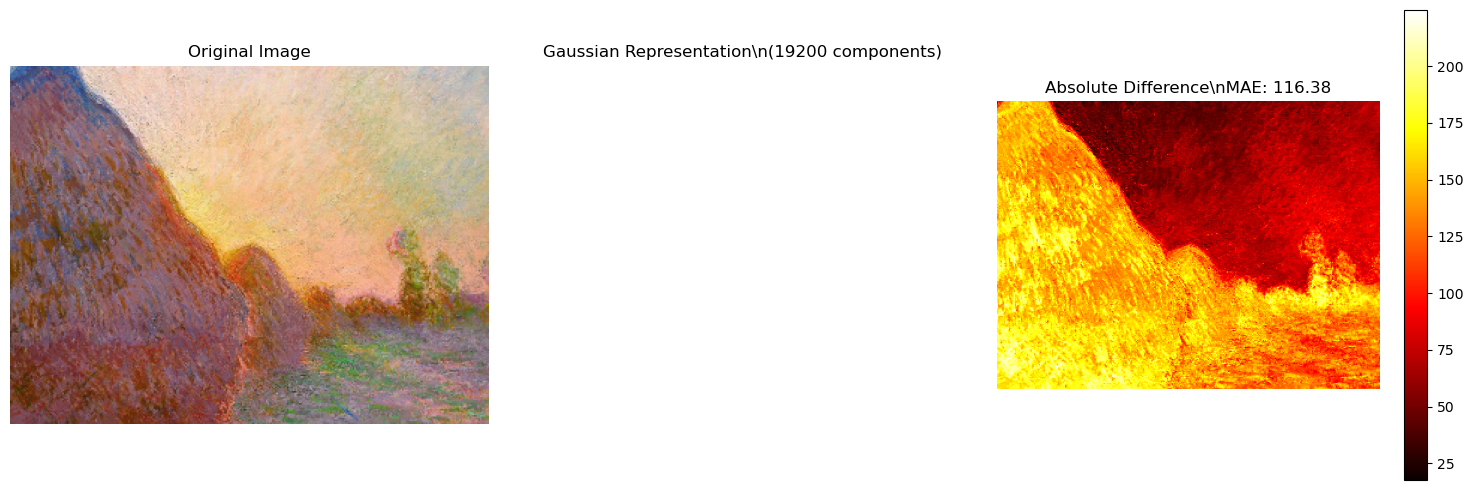

mixture model 5000 components


In [ ]:
haystack_image = np.array(Image.open("heystacks.jpg"))
haystack_large = cv2.resize(haystack_image, (320, 240))

print("grid fitting")
grid_repr = GaussianFitter.fit_grid_based(haystack_large, grid_size=2)
visualize_gaussians(grid_repr, haystack_large)

print("mixture model 5000 components")
gmm_repr = GaussianFitter.fit_mixture_model(haystack_large, n_components=5000)
visualize_gaussians(gmm_repr, haystack_large)

print("adaptive fitting 5000 iterations")
adaptive_repr = GaussianFitter.fit_adaptive(haystack_large, max_components=5000, error_threshold=2.0)
visualize_gaussians(adaptive_repr, haystack_large)


In [12]:
class GaussianImageRepresentation:    
    def __init__(self, width: int, height: int, channels: int = 3):
        self.width = width
        self.height = height
        self.channels = channels
        self.gaussians: List[Gaussian2D] = []
    
    def add_gaussian(self, gaussian: Gaussian2D):
        self.gaussians.append(gaussian)
    
    def render(self, supersample: int = 1) -> np.ndarray:
        render_width = self.width * supersample
        render_height = self.height * supersample
        
        x = np.linspace(0, self.width - 1, render_width)
        y = np.linspace(0, self.height - 1, render_height)
        X, Y = np.meshgrid(x, y)
        
        if self.channels == 1:
            image = np.zeros((render_height, render_width))
        else:
            image = np.zeros((render_height, render_width, self.channels))
        
        for gaussian in self.gaussians:
            x_min, y_min, x_max, y_max = gaussian.get_bounding_box()
            
            x_min = max(0, x_min * supersample)
            y_min = max(0, y_min * supersample)
            x_max = min(render_width, x_max * supersample)
            y_max = min(render_height, y_max * supersample)
            
            if x_min >= x_max or y_min >= y_max:
                continue
                
            X_region = X[y_min:y_max, x_min:x_max]
            Y_region = Y[y_min:y_max, x_min:x_max]
            
            gaussian_values = gaussian.evaluate_at(X_region, Y_region)
            
            if self.channels == 1:
                image[y_min:y_max, x_min:x_max] += gaussian_values * gaussian.color
            else:
                for c in range(self.channels):
                    image[y_min:y_max, x_min:x_max, c] += gaussian_values * gaussian.color[c]
        
        if supersample > 1:
            if self.channels == 1:
                image = cv2.resize(image, (self.width, self.height), interpolation=cv2.INTER_AREA)
            else:
                image = cv2.resize(image, (self.width, self.height), interpolation=cv2.INTER_AREA)
        
        return np.clip(image, 0, 255).astype(np.uint8)
    
    def get_compression_ratio(self, original_image: np.ndarray) -> float:
        original_size = original_image.size * 8
        
        gaussian_size = (6 + self.channels) * 32
        compressed_size = len(self.gaussians) * gaussian_size
        
        return original_size / compressed_size
    
    def save_gaussians(self, filename: str):
        data = []
        for g in self.gaussians:
            data.append([g.mu_x, g.mu_y, g.sigma_xx, g.sigma_yy, g.sigma_xy, 
                        g.amplitude] + g.color.tolist())
        np.save(filename, data)
    
    def load_gaussians(self, filename: str):
        data = np.load(filename)
        self.gaussians = []
        for row in data:
            color = row[6:6+self.channels]
            gaussian = Gaussian2D(
                mu_x=row[0], mu_y=row[1],
                sigma_xx=row[2], sigma_yy=row[3], sigma_xy=row[4],
                amplitude=row[5], color=color
            )
            self.gaussians.append(gaussian)
